In [1]:
pip install opencv-contrib-python-headless==4.4.0.42

     |████████████████████████████████| 42.8 MB 1.2 MB/s 


In [198]:
#Params, to be added in future
TRAIN_SPLIT=0.7
TEST_SPLIT=0.3
K_CLUSTER=500

In [2]:
import datetime

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage 

import cv2

import sklearn
from sklearn.cluster import KMeans


#import dataset
it's working for images with low resolution like cifar as currently we only have SIFT as feature extractor.

In [ ]:
import tensorflow_datasets as tfds
dataset = tfds.load("tf_flowers", as_supervised=True)

def dataset_to_numpy(ds):
    """
    Convert tensorflow dataset to numpy arrays
    """
    images = []
    labels = []

    # Iterate over a dataset
    for i,(image,label)  in enumerate(tfds.as_numpy(ds)):
        images.append(image)
        labels.append(label)

    for i, img in enumerate(images):
        if i < 3:
            print(img.shape, labels[i])

    return images, labels
images,labels=dataset_to_numpy(dataset['train'])

In [200]:
train_images=images[0:int(len(images)*TRAIN_SPLIT)]
train_labels=labels[0:int(len(images)*TRAIN_SPLIT)]
test_images=images[int(len(images)*TRAIN_SPLIT):]
test_labels=labels[int(len(images)*TRAIN_SPLIT):]

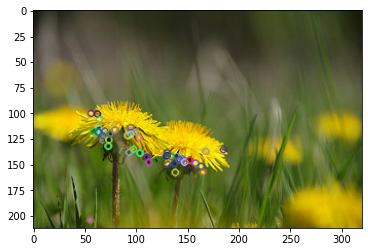

In [204]:
#view SIFT descriptors
sift=cv2.SIFT_create(nfeatures=50,contrastThreshold=0.09)
img=images[5]
#img = cv2.UMat(img).get()
kp1,des1=sift.detectAndCompute(img, None)
cv2.drawKeypoints(images[5],kp1,img)
plt.imshow(img) 

#Bag of Features

In [207]:
def get_all_des(images):
  #get all the SIFT descriptors
  sift=cv2.SIFT_create(nfeatures=50,contrastThreshold=0.09)
  des=[]
  for i,img in enumerate(images):
    print("\r[calculating sift] {}/{}".format(i+1,len(images)),end='')
    kp_,des_=sift.detectAndCompute(img,None)
    if i==0:
      des_all=des_
      continue
    if kp_==[]:
      #in case some pictures have no sift
      continue
    des_all=np.concatenate((des_all,des_))

  print("\nall sift calculated, there are {} sift in the given x".format(len(des_all)))
  return des_all

def get_kmeans(k,des_all,save=True,filename="sift_kmeans"):
  print("\n started KMeans clustering at {}".format(str(datetime.datetime.now())))
  print("\n{} SIFTs clustering into {} clusters".format(len(des_all),k))
  kmeans=KMeans(n_clusters=k,verbose=0).fit(des_all)
  if save==True:
    filename=filename+str([k])
    joblib.dump(kmeans,filename)
    print("saved as {}".format(filename))
  print("\nclustering done at {}\n".format(str(datetime.datetime.now())))
  return kmeans

def get_bow(kmeans,images):
  #change SIFT descriptors to its nearest cluster centre
  k=kmeans.n_clusters
  bag_of_features=[]
  sift=cv2.SIFT_create()
  i=0
  for i,img in enumerate(images):
    print("\r[recalculating sift with kmeans] {}/{}".format(i+1,len(images)),end='')
    _,des=sift.detectAndCompute(img,None)
    sift_clustered=[0]*k
    if type(des)!=np.ndarray or len(des)==0:
      pass
    else:
      for d in des:
        thissift=kmeans.predict(d.reshape(1,-1))[0]#predict result is the i of kmeans.cluster_center_[i]
        sift_clustered[thissift]+=1
    bag_of_features.append(sift_clustered)
    del _
    del des

  print("\nbag of features construction finished\n")
  return(bag_of_features)

In [208]:
des_all=get_all_des(train_images)
kmeans=get_kmeans(K_CLUSTER,des_all,save=False)
train_bow=get_bow(kmeans,train_images)
test_bow=get_bow(kmeans,test_images)

[calculating sift] 2569/2569
all sift calculated, there are 122777 sift in the given x


#Classify


In [211]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

mlp=MLPClassifier((500,),max_iter=50).fit(train_bow,train_labels)


print("Accuracy for train set:")
pred_y=mlp.predict(train_bow)
eval_result=accuracy_score(train_labels, pred_y)
print(eval_result)

print("Accuracy for test set:")
pred_y=mlp.predict(test_bow)
eval_result=accuracy_score(test_labels, pred_y)
print(eval_result)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy for train set:
1.0
Accuracy for test set:
0.6176203451407811
